In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

from tqdm import tqdm
from scipy.stats import poisson
from scipy.optimize import minimize

import warnings
warnings.filterwarnings('ignore')

## Model with home bonus

In [2]:
real_pars = np.random.gamma(2, 0.5, 40)

bounds = list()
inx = dict()
ind = 0
for i in range(1, 21):
    inx[f'Clube {i}'] = dict()
    inx[f'Clube {i}']['Atk'] = ind
    if ind != 0: bounds.append((0, None))
    ind += 1
    inx[f'Clube {i}']['Def'] = ind
    bounds.append((0, None))
    ind += 1

inx['Home bonus'] = ind
bounds.append((0, None))

pars = real_pars / real_pars[0]
pars[:-1] = pars[1:]
pars[-1] = 0

In [3]:
def simulate_games(real_pars):
    games = dict()
    for i in range(1, 21):
        games[f'Clube {i}'] = dict()
        for j in range(1, 21):
            if i == j: continue
            home = np.random.poisson(real_pars[inx[f'Clube {i}']['Atk']] / real_pars[inx[f'Clube {j}']['Def']])
            away = np.random.poisson(real_pars[inx[f'Clube {j}']['Atk']] / real_pars[inx[f'Clube {i}']['Def']])
            games[f'Clube {i}'][f'Clube {j}'] = [home, away]

    return games

In [4]:
def likelihood(parameters, played_games, inx):
    lik = 0
    for home in played_games:
        for away in played_games[home]:
            result = played_games[home][away]
            inx_1, inx_2 = inx[home]['Atk'] - 1, inx[away]['Def'] - 1
            if parameters[inx_2] == 0: return np.inf
            if inx_1 == -1: mu0 = 1 / parameters[inx_2] + parameters[-1]
            else: mu0 = parameters[inx_1] / parameters[inx_2] + parameters[-1]
            lik -= poisson.logpmf(result[0], mu0)

            inx_1, inx_2 = inx[away]['Atk'] - 1, inx[home]['Def'] - 1
            if parameters[inx_2] == 0: return np.inf
            if inx_1 == -1: mu1 = 1 / parameters[inx_2]
            else: mu1 = parameters[inx_1] / parameters[inx_2]
            lik -= poisson.logpmf(result[1], mu1)
    
    return lik

In [5]:
fun_values, lik_values, estimated_pars = list(), list(), list()
for sim in tqdm(range(200)):
    games = simulate_games(real_pars)
    res = minimize(likelihood, np.random.random(2 * len(games)),
                args = (games, inx), bounds = bounds)

    fun_values.append(res.fun)
    estimated_pars.append(res.x)
    lik_values.append(likelihood(pars, games, inx))

100%|██████████| 200/200 [26:47<00:00,  8.04s/it] 


In [6]:
cols = list()
for i in range(1, 21):
    if i != 1: cols.append(f'Atk - clube {i}')
    cols.append(f'Def - clube {i}')

cols.append('Home bonus')
df = pd.DataFrame(np.array(estimated_pars), columns = cols).quantile([0.025, 0.975]).T
df['Real'] = pars
df['In interval'] = (df[0.025] < df['Real']).values * (df['Real'] < df[0.975]).values
print(f'Real values in confidence interval: {df.sum()["In interval"] / len(df):.2%}')

Real values in confidence interval: 35.00%


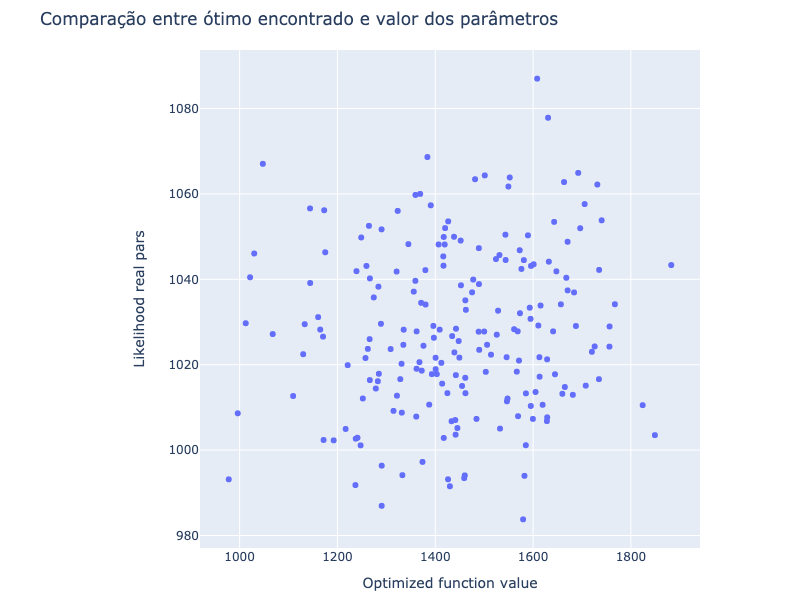

In [7]:
data = go.Scatter(x = fun_values,
                  y = lik_values,
                  mode = 'markers')

layout = go.Layout(title = 'Comparação entre ótimo encontrado e valor dos parâmetros',
                   xaxis = dict(title = 'Optimized function value'),
                   yaxis = dict(title = 'Likelihood real pars'),
                   autosize = False,
                   width = 800,
                   height = 600,
                   margin = dict(l = 200, r = 100, b = 50, t = 50))

fig = go.Figure(data, layout = layout)
fig.show('png')

In [8]:
df

,0.025,0.975,Real,In interval
Def - clube 1,0.313124,1.024367,1.453113,False
Atk - clube 2,0.216007,1.129364,1.319178,False
Def - clube 2,0.235873,1.002632,0.831725,True
Atk - clube 3,0.299238,2.103477,2.661620,False
Def - clube 3,0.195269,0.946151,0.675918,True
Atk - clube 4,0.314997,3.782752,4.249737,False
Def - clube 4,0.229912,0.964879,0.698025,True
Atk - clube 5,0.106435,0.934698,0.598278,True
Def - clube 5,0.336180,2.930965,4.518451,False
Atk - clube 6,0.356402,3.820901,4.789193,False


## Model without home bonus

In [9]:
real_pars = np.random.gamma(2, 0.5, 40)

bounds = list()
inx = dict()
ind = 0
for i in range(1, 21):
    inx[f'Clube {i}'] = dict()
    inx[f'Clube {i}']['Atk'] = ind
    if ind != 0: bounds.append((0, None))
    ind += 1
    inx[f'Clube {i}']['Def'] = ind
    bounds.append((0, None))
    ind += 1

pars = real_pars / real_pars[0]
pars = pars[1:]

In [10]:
def likelihood(parameters, played_games, inx):
    lik = 0
    for home in played_games:
        for away in played_games[home]:
            result = played_games[home][away]
            inx_1, inx_2 = inx[home]['Atk'] - 1, inx[away]['Def'] - 1
            if parameters[inx_2] == 0: return np.inf
            if inx_1 == -1: mu0 = 1 / parameters[inx_2]
            else: mu0 = parameters[inx_1] / parameters[inx_2]
            lik -= poisson.logpmf(result[0], mu0)

            inx_1, inx_2 = inx[away]['Atk'] - 1, inx[home]['Def'] - 1
            if parameters[inx_2] == 0: return np.inf
            if inx_1 == -1: mu1 = 1 / parameters[inx_2]
            else: mu1 = parameters[inx_1] / parameters[inx_2]
            lik -= poisson.logpmf(result[1], mu1)
    
    return lik

In [12]:
fun_values, lik_values, estimated_pars = list(), list(), list()
for sim in tqdm(range(200)):
    games = simulate_games(real_pars)
    res = minimize(likelihood, np.random.random(2 * len(games) - 1),
                args = (games, inx), bounds = bounds)

    fun_values.append(res.fun)
    estimated_pars.append(res.x)
    lik_values.append(likelihood(pars, games, inx))

100%|██████████| 200/200 [20:14<00:00,  6.07s/it]  


In [14]:
cols = list()
for i in range(1, 21):
    if i != 1: cols.append(f'Atk - clube {i}')
    cols.append(f'Def - clube {i}')

df = pd.DataFrame(np.array(estimated_pars), columns = cols).quantile([0.025, 0.975]).T
df['Real'] = pars
df['In interval'] = (df[0.025] < df['Real']).values * (df['Real'] < df[0.975]).values
print(f'Real values in confidence interval: {df.sum()["In interval"] / len(df):.2%}')

Real values in confidence interval: 53.85%


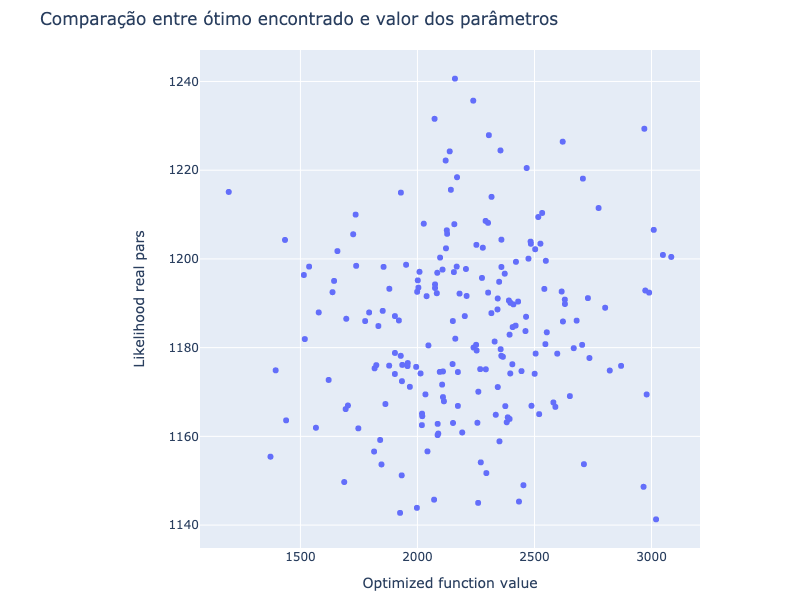

In [15]:
data = go.Scatter(x = fun_values,
                  y = lik_values,
                  mode = 'markers')

layout = go.Layout(title = 'Comparação entre ótimo encontrado e valor dos parâmetros',
                   xaxis = dict(title = 'Optimized function value'),
                   yaxis = dict(title = 'Likelihood real pars'),
                   autosize = False,
                   width = 800,
                   height = 600,
                   margin = dict(l = 200, r = 100, b = 50, t = 50))

fig = go.Figure(data, layout = layout)
fig.show('png')

In [16]:
df

,0.025,0.975,Real,In interval
Def - clube 1,0.169806,0.967233,0.483815,True
Atk - clube 2,0.074888,0.948310,0.122568,True
Def - clube 2,0.228160,1.005716,1.044116,False
Atk - clube 3,0.266709,1.064589,2.037405,False
Def - clube 3,0.077777,0.932333,0.242868,True
Atk - clube 4,0.195964,0.987179,1.452965,False
Def - clube 4,0.083549,0.912408,0.205508,True
Atk - clube 5,0.309863,1.110364,2.354650,False
Def - clube 5,0.234754,0.998459,0.840474,True
Atk - clube 6,0.255363,1.029762,1.804231,False
